In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass
from functools import partial
from typing import List, Callable


import pandas as pd
from tqdm.notebook import tqdm
from transformer_lens import ActivationCache
from src import *
from src.patching_helpers import clean_toxic_logit_diff, get_resid_cache_from_forward_pass, patching_hook, attn_head_patching_hook

/root/quirky_interp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load model and dataset

In [3]:
personas = {
    "lenient": "You are lenient on toxicity\n",
    "harsh": "You are harsh on toxicity\n"
}

possible_labels = ("CLEAN", "TOXIC")

classifier_prompt = """
You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

In [4]:
model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"

hf_model, hf_tokenizer = load_model_from_transformers(model_name_or_path)
model = from_hf_to_tlens(hf_model, hf_tokenizer, "llama-13b")

Loading checkpoint shards: 100%|██████████| 3/3 [01:51<00:00, 37.08s/it]


Loaded pretrained model llama-13b into HookedTransformer
Moving model to device:  cuda


# Setup

### Load data

In [5]:
toxicity_data = pd.read_json("data/simple_toxic_data_filtered.jsonl", lines=True)
sequences = toxicity_data["prompt"].tolist()

### Experiment Helpers

In [6]:
PERSONA_START_IDX = 0  # at what token position does the persona start?
PERSONA_END_IDX = 10  # at what token position does the persona end?
SEQUENCE_START_IDX = 51  # at what token position does the sequence start?
SEQUENCE_END_IDX_OFFSET = 5  # in the full prompt, how many tokens are there after the sequence ends?

In [7]:
prompt = personas["lenient"] + classifier_prompt.format(sequence=sequences[0])

prompt_str_tokens = model.to_str_tokens(prompt)

Keyword arguments {'add_special_tokens': False} not recognized.


# Patch Patching

In [7]:
@dataclass
class Region:
    positions: List[int]
    layers: List[int]

    def get_downstream_region(self, model: HookedTransformer, prompt: str):
        tokens = model.to_tokens(prompt)
        downstream_positions = list(range(min(self.positions), len(tokens[0])))
        downstream_layers = list(range(min(self.layers), model.cfg.n_layers))
        return Region(downstream_positions, downstream_layers).subtract_region(self)
    
    def add_resid_hooks_in_region(self, model: HookedTransformer, hook: Callable, cache: ActivationCache):
        for layer in self.layers:
            temp_hook = partial(
                hook,
                cache=cache,
                position=self.positions,
            )
            model.blocks[layer].hook_resid_post.add_hook(temp_hook)

    
    def subtract_region(self, other: "Region"):
        return Region(
            [pos for pos in self.positions if pos not in other.positions],
            other.layers
        )


In [86]:
def resid_path_patching(
    model: HookedTransformer,
    sender_prompt: str,
    receiver_prompt: str,
    sender_region: Region,
    receiver_region: Region
):
    # 1. Cache activations from sender and receiver inputs
    sender_logits, sender_cache = get_resid_cache_from_forward_pass(model, sender_prompt)
    receiver_logits, receiver_cache = get_resid_cache_from_forward_pass(model, receiver_prompt)

    sender_logit_diff = clean_toxic_logit_diff(sender_logits)
    receiver_logit_diff = clean_toxic_logit_diff(receiver_logits)
    
    # 2. Get impact of direct path from source region to target region
    # 2.1. Add hooks for patching in sender activations from sender region
    sender_region.add_resid_hooks_in_region(model, patching_hook, sender_cache)

    # 2.2 Freeze activations from nodes that are downstream of the sender region but not in the receiver region
    downstream_of_sender = sender_region.get_downstream_region(model, receiver_prompt)
    downstream_region_to_freeze = downstream_of_sender.subtract_region(receiver_region)
    downstream_region_to_freeze.add_resid_hooks_in_region(model, patching_hook, receiver_cache)

    # 2.3 Do a forward pass with the current patching setup and cache activations in receiver region
    _, intervened_receiver_cache = get_resid_cache_from_forward_pass(model, receiver_prompt, layers=receiver_region.layers)
    model.reset_hooks()
    
    # 3. Patch in the intervened activations into a forward pass with the original receiver prompt
    receiver_region.add_resid_hooks_in_region(model, patching_hook, intervened_receiver_cache)
    with torch.no_grad():
        receiver_tokens = model.to_tokens(receiver_prompt)
        patched_logits = model(receiver_tokens).to("cpu")
    patched_logit_diff = clean_toxic_logit_diff(patched_logits)

    # what percentage of the sender logit diff has the patch recovered?
    if sender_logit_diff - receiver_logit_diff != 0:
        score = float(abs(patched_logit_diff - receiver_logit_diff) / abs(sender_logit_diff - receiver_logit_diff).item())
    elif patched_logit_diff == receiver_logit_diff:
        score = 1
    else:
        score = 0

    model.reset_hooks()
    return score    

In [9]:
PERSONA_START_IDX = 0  # at what token position does the persona start?
PERSONA_END_IDX = 10  # at what token position does the persona end?
SEQUENCE_START_IDX = 51  # at what token position does the sequence start?
SEQUENCE_END_IDX_OFFSET = 5  # in the full prompt, how many tokens are there after the sequence ends?

In [93]:
def path_patching_personas_from_s_before_t_to_f_before_t(
    model: HookedTransformer,
    sender_persona_prompt: str,
    recevier_persona_prompt: str,
    sequences: list[str],
    layers_below_t: int,
    recevier_position_offset: int = 1,
):
    ld_recovered_lst = []

    for sequence in tqdm(sequences):
        sender_prompt = sender_persona_prompt + classifier_prompt.format(sequence=sequence)
        receiver_prompt = recevier_persona_prompt + classifier_prompt.format(sequence=sequence)

        n_tokens = len(model.to_str_tokens(sender_prompt))
        recevier_positions = [n_tokens - offset for offset in range(recevier_position_offset, 0, -1)]

        sender_region = Region(
            positions=list(range(SEQUENCE_START_IDX, n_tokens - SEQUENCE_END_IDX_OFFSET)),
            layers=list(range(layers_below_t))
        )
        receiver_region = Region(
            positions=recevier_positions,
            layers=list(range(layers_below_t))
        )

        ld_recovered = resid_path_patching(
            model,
            sender_prompt,
            receiver_prompt,
            sender_region,
            receiver_region
        )
        ld_recovered_lst.append(ld_recovered)

    return np.mean(ld_recovered_lst), ld_recovered_lst

In [115]:
def path_patching_personas_from_p_to_f(
    model: HookedTransformer,
    sender_persona_prompt: str,
    recevier_persona_prompt: str,
    sequences: list[str],
    layers_below_t: int,
    recevier_position_offset: int = 1,
):
    ld_recovered_lst = []

    for sequence in tqdm(sequences):
        sender_prompt = sender_persona_prompt + classifier_prompt.format(sequence=sequence)
        receiver_prompt = recevier_persona_prompt + classifier_prompt.format(sequence=sequence)

        n_tokens = len(model.to_str_tokens(sender_prompt))
        recevier_positions = [n_tokens - offset for offset in range(recevier_position_offset, 0, -1)]

        sender_region = Region(
            positions=list(range(PERSONA_START_IDX, PERSONA_END_IDX + 1)),
            layers=list(range(layers_below_t))
        )
        receiver_region = Region(
            positions=recevier_positions,
            layers=list(range(layers_below_t))
        )

        ld_recovered = resid_path_patching(
            model,
            sender_prompt,
            receiver_prompt,
            sender_region,
            receiver_region
        )
        ld_recovered_lst.append(ld_recovered)

    return np.mean(ld_recovered_lst), ld_recovered_lst

In [21]:
def path_patching_sequences_from_s_before_t_to_f_before_t(
    model: HookedTransformer,
    sender_sequence: str,
    receiver_sequence: str,
    layers_below_t: int,
    persona_prompts: List[str] | None = None,
    recevier_position_offset: int = 1,
):
    ld_recovered_lst = []

    persona_prompts = persona_prompts if persona_prompts is not None else [personas["lenient"]]

    for persona_prompt in persona_prompts:
        sender_prompt = persona_prompt + classifier_prompt.format(sequence=sender_sequence)
        receiver_prompt = persona_prompt + classifier_prompt.format(sequence=receiver_sequence)

        n_tokens = len(model.to_str_tokens(sender_prompt))
        recevier_positions = [n_tokens - offset for offset in range(recevier_position_offset, 0, -1)]

        sender_region = Region(
            positions=list(range(SEQUENCE_START_IDX, n_tokens - SEQUENCE_END_IDX_OFFSET)),
            layers=list(range(layers_below_t))
        )
        receiver_region = Region(
            positions=recevier_positions,
            layers=list(range(layers_below_t))
        )

        ld_recovered = resid_path_patching(
            model,
            sender_prompt,
            receiver_prompt,
            sender_region,
            receiver_region
        )
        ld_recovered_lst.append(ld_recovered)

    return np.mean(ld_recovered_lst), ld_recovered_lst

# Path Patch from S to F 

### Patching in different sequences

In [84]:
sequence_pairs = [
    ("You are very smart", "You are very stupid"),
    ("You are very stupid", "You are very smart"),
    ("The spinach is great because it tastes good", "The spinach is bad because it tastes weird"),
    ("The spinach is bad because it tastes weird", "The spinach is great because it tastes good"),
    ("The dog is cute because it is small", "The dog is ugly because it is smelly"),
    ("The dog is ugly because it is smelly", "The dog is cute because it is small"),
    ("The game is unoriginal because it copies", "The game is novel because it innovates"),
    ("The game is novel because it innovates", "The game is unoriginal because it copies"),
    ("That person is nice because they are kind", "That person is bad because they are mean"),
    ("That person is bad because they are mean", "That person is nice because they are kind"),
    ("The teacher is great because she cares", "The teacher is bad because she snores"),
    ("The teacher is bad because she snores", "The teacher is great because she cares"),
    ("People are nice because they do kind things", "People are bad because they do mean things"),
    ("People are bad because they do mean things", "People are nice because they do kind things"),
    ("The book was really interesting because it surprised me", "The book was lame because it was slow"),
    ("The book was lame because it was slow", "The book was really interesting because it surprised me")
]

In [ ]:
receiver_positions = [57, 58, 59, 60, 61]
recevier_position_offset = SEQUENCE_END_IDX_OFFSET

model.reset_hooks()

thresholds_to_investigate = list(range(10,21))

ld_recovered_mean_by_layer = []
ld_recovered_std_by_layer = []
ld_recovered_by_layer = []

for layers_below_t in tqdm(thresholds_to_investigate):
    lds_recovered = []
    for seq1, seq2 in sequence_pairs:
        ld_recovered_seq_patch, _ = path_patching_sequences_from_s_before_t_to_f_before_t(
            model,
            seq1,
            seq2,
            layers_below_t,
            recevier_position_offset=recevier_position_offset
        )
        lds_recovered.append(ld_recovered_seq_patch)

    ld_recovered_mean = np.mean(lds_recovered)
    ld_recovered_std = np.std(lds_recovered)
    ld_recovered_mean_by_layer.append(ld_recovered_mean)
    ld_recovered_std_by_layer.append(ld_recovered_std)
    ld_recovered_by_layer.append(lds_recovered)

In [ ]:
model.reset_hooks()

ld_recovered_mean_by_layer_last_pos = []
ld_recovered_std_by_layer_last_pos = []
ld_recovered_by_layer_last_post = []

for layers_below_t in tqdm(thresholds_to_investigate):
    lds_recovered = []
    for seq1, seq2 in sequence_pairs:
        ld_recovered_seq_patch, _ = path_patching_sequences_from_s_before_t_to_f_before_t(
            model,
            seq1,
            seq2,
            layers_below_t,
            recevier_position_offset=1
        )
        lds_recovered.append(ld_recovered_seq_patch)

    ld_recovered_mean = np.mean(lds_recovered)
    ld_recovered_std = np.std(lds_recovered)
    ld_recovered_mean_by_layer_last_pos.append(ld_recovered_mean)
    ld_recovered_std_by_layer_last_pos.append(ld_recovered_std)
    ld_recovered_by_layer_last_post.append(lds_recovered)

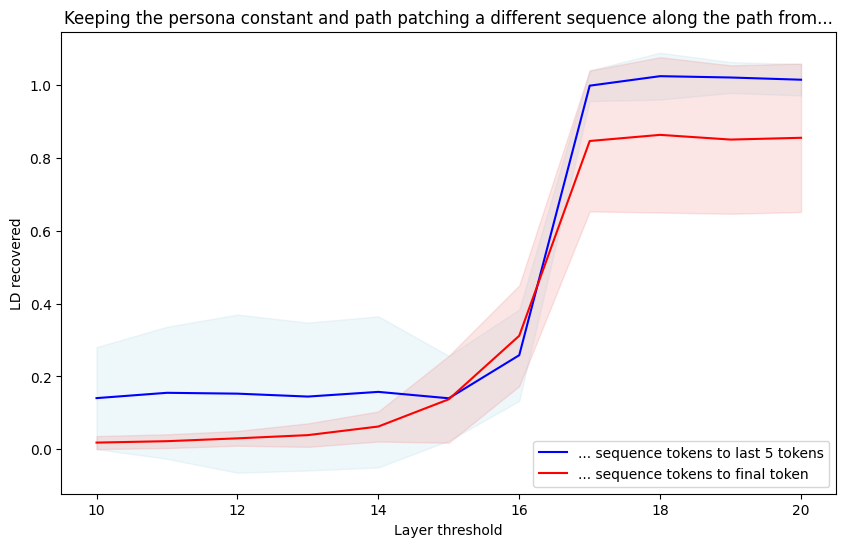

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Increase the figure size

plt.title("Keeping the persona constant and path patching a different sequence along the path from...")
plt.plot(thresholds_to_investigate, ld_recovered_mean_by_layer, color='blue', label="... sequence tokens to last 5 tokens")
plt.fill_between(thresholds_to_investigate, np.array(ld_recovered_mean_by_layer) - np.array(ld_recovered_std_by_layer), np.array(ld_recovered_mean_by_layer) + np.array(ld_recovered_std_by_layer), color='lightblue', alpha=0.2)
plt.plot(thresholds_to_investigate, ld_recovered_mean_by_layer_last_pos, color='red', label="... sequence tokens to final token")
plt.fill_between(thresholds_to_investigate, np.array(ld_recovered_mean_by_layer_last_pos) - np.array(ld_recovered_std_by_layer_last_pos), np.array(ld_recovered_mean_by_layer_last_pos) + np.array(ld_recovered_std_by_layer_last_pos), color='lightcoral', alpha=0.2)

plt.xlabel('Layer threshold')
plt.ylabel('LD recovered')

# Move the legend to the bottom left
plt.legend(loc='lower right')

plt.show()


### Patching in different persona prompts

In [ ]:
receiver_positions = [57, 58, 59, 60, 61]
recevier_position_offset = SEQUENCE_END_IDX_OFFSET

model.reset_hooks()

thresholds_to_investigate = list(range(10,21))

p_patching_ld_recovered_mean_by_layer = []
p_patching_ld_recovered_std_by_layer = []
p_patching_ld_recovered_by_layer = []

for layers_below_t in tqdm(thresholds_to_investigate):
    _, lds_recovered = path_patching_personas_from_s_before_t_to_f_before_t(
        model,
        personas["lenient"],
        personas["harsh"],
        sequences[:20],
        layers_below_t,
        recevier_position_offset=recevier_position_offset
    )
    lds_recovered.append(ld_recovered_seq_patch)

    ld_recovered_mean = np.mean(lds_recovered)
    ld_recovered_std = np.std(lds_recovered)
    p_patching_ld_recovered_mean_by_layer.append(ld_recovered_mean)
    p_patching_ld_recovered_std_by_layer.append(ld_recovered_std)
    p_patching_ld_recovered_by_layer.append(lds_recovered)

In [ ]:
model.reset_hooks()
p_patching_ld_recovered_mean_by_layer_last_pos = []
p_patching_ld_recovered_std_by_layer_last_pos = []
p_patching_ld_recovered_by_layer_last_pos = []

for layers_below_t in tqdm(thresholds_to_investigate):
    _, lds_recovered = path_patching_personas_from_s_before_t_to_f_before_t(
        model,
        personas["lenient"],
        personas["harsh"],
        sequences[:20],
        layers_below_t,
        recevier_position_offset=1
    )
    lds_recovered.append(ld_recovered_seq_patch)

    ld_recovered_mean = np.mean(lds_recovered)
    ld_recovered_std = np.std(lds_recovered)
    p_patching_ld_recovered_mean_by_layer_last_pos.append(ld_recovered_mean)
    p_patching_ld_recovered_std_by_layer_last_pos.append(ld_recovered_std)
    p_patching_ld_recovered_by_layer_last_pos.append(lds_recovered)

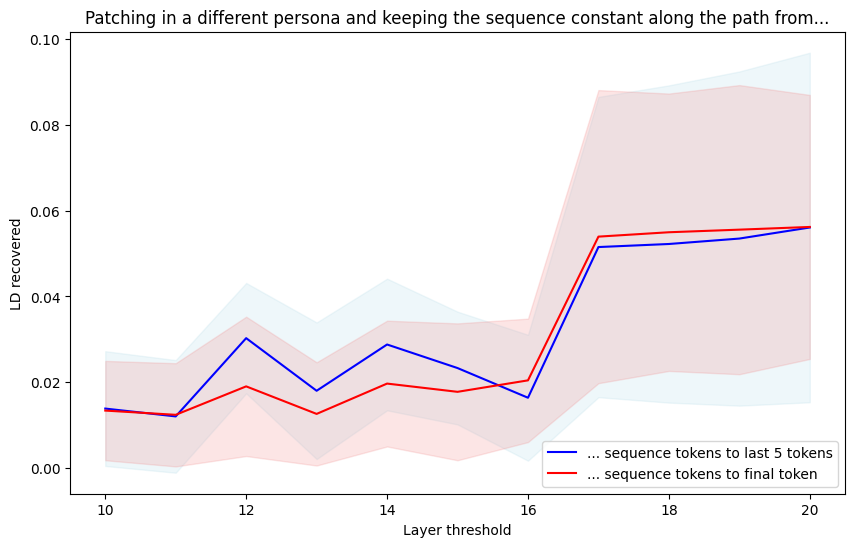

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Increase the figure size

plt.title("Patching in a different persona and keeping the sequence constant along the path from...")
plt.plot(thresholds_to_investigate, p_patching_ld_recovered_mean_by_layer, color='blue', label="... sequence tokens to last 5 tokens")
plt.fill_between(thresholds_to_investigate, np.array(p_patching_ld_recovered_mean_by_layer) - np.array(p_patching_ld_recovered_std_by_layer), np.array(p_patching_ld_recovered_mean_by_layer) + np.array(p_patching_ld_recovered_std_by_layer), color='lightblue', alpha=0.2)
plt.plot(thresholds_to_investigate, p_patching_ld_recovered_mean_by_layer_last_pos, color='red', label="... sequence tokens to final token")
plt.fill_between(thresholds_to_investigate, np.array(p_patching_ld_recovered_mean_by_layer_last_pos) - np.array(p_patching_ld_recovered_std_by_layer_last_pos), np.array(p_patching_ld_recovered_mean_by_layer_last_pos) + np.array(p_patching_ld_recovered_std_by_layer_last_pos), color='lightcoral', alpha=0.2)

plt.xlabel('Layer threshold')
plt.ylabel('LD recovered')

# Move the legend to the bottom left
plt.legend(loc='lower right')

plt.show()

# Patching from P to F

In [ ]:
thresholds_to_investigate = list(range(1, model.cfg.n_layers))

recevier_position_offset = SEQUENCE_END_IDX_OFFSET + 2

model.reset_hooks()
p_to_f_persona_ld_recovered_mean_by_layer_7 = []
p_to_f_persona_ld_recovered_std_by_layer_7 = []
p_to_f_persona_ld_recovered_by_layer_7 = []

for layers_below_t in tqdm(thresholds_to_investigate):
    _, lds_recovered = path_patching_personas_from_p_to_f(
        model,
        personas["lenient"],
        personas["harsh"],
        sequences[:20],
        layers_below_t,
        recevier_position_offset=recevier_position_offset
    )

    ld_recovered_mean = np.mean(lds_recovered)
    ld_recovered_std = np.std(lds_recovered)
    p_to_f_persona_ld_recovered_mean_by_layer_7.append(ld_recovered_mean)
    p_to_f_persona_ld_recovered_std_by_layer_7.append(ld_recovered_std)
    p_to_f_persona_ld_recovered_by_layer_7.append(lds_recovered)

In [ ]:
thresholds_to_investigate = list(range(1, model.cfg.n_layers))

recevier_position_offset = SEQUENCE_END_IDX_OFFSET

model.reset_hooks()
p_to_f_persona_ld_recovered_mean_by_layer = []
p_to_f_persona_ld_recovered_std_by_layer = []
p_to_f_persona_ld_recovered_by_layer = []

for layers_below_t in tqdm(thresholds_to_investigate):
    _, lds_recovered = path_patching_personas_from_p_to_f(
        model,
        personas["lenient"],
        personas["harsh"],
        sequences[:20],
        layers_below_t,
        recevier_position_offset=recevier_position_offset
    )

    ld_recovered_mean = np.mean(lds_recovered)
    ld_recovered_std = np.std(lds_recovered)
    p_to_f_persona_ld_recovered_mean_by_layer.append(ld_recovered_mean)
    p_to_f_persona_ld_recovered_std_by_layer.append(ld_recovered_std)
    p_to_f_persona_ld_recovered_by_layer.append(lds_recovered)

In [ ]:
thresholds_to_investigate = list(range(1, model.cfg.n_layers))

model.reset_hooks()
p_to_f_persona_ld_recovered_mean_by_layer_last_pos = []
p_to_f_persona_ld_recovered_std_by_layer_last_pos = []
p_to_f_persona_ld_recovered_by_layer_last_pos = []

for layers_below_t in tqdm(thresholds_to_investigate):
    _, lds_recovered = path_patching_personas_from_p_to_f(
        model,
        personas["lenient"],
        personas["harsh"],
        sequences[:20],
        layers_below_t,
        recevier_position_offset=1
    )

    ld_recovered_mean = np.mean(lds_recovered)
    ld_recovered_std = np.std(lds_recovered)
    p_to_f_persona_ld_recovered_mean_by_layer_last_pos.append(ld_recovered_mean)
    p_to_f_persona_ld_recovered_std_by_layer_last_pos.append(ld_recovered_std)
    p_to_f_persona_ld_recovered_by_layer_last_pos.append(lds_recovered)

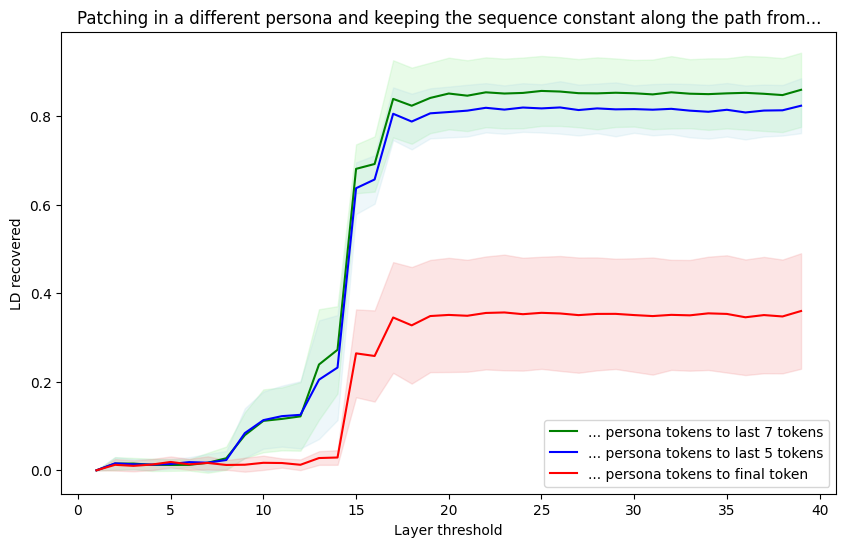

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Increase the figure size

plt.title("Patching in a different persona and keeping the sequence constant along the path from...")
plt.plot(thresholds_to_investigate, p_to_f_persona_ld_recovered_mean_by_layer_7, color='green', label="... persona tokens to last 7 tokens")
plt.fill_between(thresholds_to_investigate, np.array(p_to_f_persona_ld_recovered_mean_by_layer_7) - np.array(p_to_f_persona_ld_recovered_std_by_layer_7), np.array(p_to_f_persona_ld_recovered_mean_by_layer_7) + np.array(p_to_f_persona_ld_recovered_std_by_layer_7), color='lightgreen', alpha=0.2)
plt.plot(thresholds_to_investigate, p_to_f_persona_ld_recovered_mean_by_layer, color='blue', label="... persona tokens to last 5 tokens")
plt.fill_between(thresholds_to_investigate, np.array(p_to_f_persona_ld_recovered_mean_by_layer) - np.array(p_to_f_persona_ld_recovered_std_by_layer), np.array(p_to_f_persona_ld_recovered_mean_by_layer) + np.array(p_to_f_persona_ld_recovered_std_by_layer), color='lightblue', alpha=0.2)
plt.plot(thresholds_to_investigate, p_to_f_persona_ld_recovered_mean_by_layer_last_pos, color='red', label="... persona tokens to final token")
plt.fill_between(thresholds_to_investigate, np.array(p_to_f_persona_ld_recovered_mean_by_layer_last_pos) - np.array(p_to_f_persona_ld_recovered_std_by_layer_last_pos), np.array(p_to_f_persona_ld_recovered_mean_by_layer_last_pos) + np.array(p_to_f_persona_ld_recovered_std_by_layer_last_pos), color='lightcoral', alpha=0.2)

plt.xlabel('Layer threshold')
plt.ylabel('LD recovered')

# Move the legend to the bottom left
plt.legend(loc='lower right')

plt.show()

# Attention Head Patching

In [14]:
def run_z_patching_experiment(model, tokens, position, cache, metric, hook=None, **hook_kwargs):
    hook = attn_head_patching_hook if hook is None else hook
    results = []
    for layer in tqdm(range(model.cfg.n_layers)):
        layer_results = []
        for head in tqdm(range(model.cfg.n_heads), leave=False):
            model.reset_hooks()
            temp_hook = partial(
                hook,
                cache=cache,
                position=position,
                head=head,
                **hook_kwargs
            )
            model.blocks[layer].attn.hook_z.add_hook(temp_hook)

            with torch.no_grad():
                logits = model(tokens).to("cpu")
                patched_logit_diff = clean_toxic_logit_diff(logits)
                ld_recovered = metric(patched_logit_diff)
            layer_results.append(ld_recovered)
        results.append(layer_results)

    return results

In [15]:
def ld_recovered_metric(sender_logits, receiver_logits, patched_logit_diff):
    sender_logit_diff = clean_toxic_logit_diff(sender_logits)
    receiver_logit_diff = clean_toxic_logit_diff(receiver_logits)

    if sender_logit_diff - receiver_logit_diff != 0:
            score = float(abs(patched_logit_diff - receiver_logit_diff) / abs(sender_logit_diff - receiver_logit_diff).item())
    elif patched_logit_diff == receiver_logit_diff:
        score = 1
    else:
        score = 0

    return score

In [16]:
model.reset_hooks()

seq1 = sequences[0]
seq2 = sequences[1]

sender_prompt = personas["lenient"] + classifier_prompt.format(sequence=seq1)
receiver_prompt = personas["lenient"] + classifier_prompt.format(sequence=seq2)

with torch.no_grad():
    sender_tokens = model.to_tokens(sender_prompt)
    sender_logits, sender_cache = model.run_with_cache(sender_tokens)
    sender_logits = sender_logits.to("cpu")

with torch.no_grad():
    receiver_tokens = model.to_tokens(receiver_prompt)
    receiver_logits = model(receiver_tokens).to("cpu")

metric = partial(ld_recovered_metric, sender_logits, receiver_logits)

results = run_z_patching_experiment(model, receiver_tokens, -1, sender_cache, metric)


Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
  0%|          | 0/40 [00:00<?, ?it/s]


AttributeError: 'float' object has no attribute 'item'

In [ ]:
for i in range(10):
    seq1 = sequences[i]
    seq2 = sequences[i+1]

    sender_prompt = personas["lenient"] + classifier_prompt.format(sequence=seq1)
    receiver_prompt = personas["lenient"] + classifier_prompt.format(sequence=seq2)

    with torch.no_grad():
        sender_tokens = model.to_tokens(sender_prompt)
        sender_logits, sender_cache = model.run_with_cache(sender_tokens)
        sender_logits = sender_logits.to("cpu")

    with torch.no_grad():
        receiver_tokens = model.to_tokens(receiver_prompt)
        receiver_logits = model(receiver_tokens).to("cpu")

    metric = partial(ld_recovered_metric, sender_logits, receiver_logits)

    results = run_z_patching_experiment(model, tokens, position, sender_cache, metric)


# Old Stuff Below Here

In [12]:
model.reset_hooks()

In [18]:
persona_source = personas["lenient"]
persona_target = personas["harsh"]

sequence = filtered_sequences[0]
layer_wise_scores = []

for layer in tqdm(range(model.cfg.n_layers)):
    target_prompt = persona_target + classifier_prompt.format(sequence=sequence)
    target_tokens = model.to_tokens(target_prompt)

    with torch.no_grad():
        baseline_logits = model(target_tokens).to("cpu")
    
    baseline_diff = clean_toxic_logit_diff(baseline_logits).item()


    source_prompt = persona_source + classifier_prompt.format(sequence=sequence)
    source_tokens = model.to_tokens(source_prompt)

    source_logits, source_cache = get_resid_cache_from_forward_pass(model, source_tokens)
    source_diff = clean_toxic_logit_diff(source_logits).item()

    positions_to_patch = slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

    temp_hook = partial(
        patching_hook,
        cache=source_cache,
        position=positions_to_patch,
    )
    model.blocks[layer].hook_resid_post.add_hook(temp_hook)

    with torch.no_grad():
        patched_logits = model(target_tokens).to("cpu")
    
    patched_logit_diff = clean_toxic_logit_diff(patched_logits).item()

    score = abs(patched_logit_diff - baseline_diff) / abs(source_diff - baseline_diff)
    layer_wise_scores.append(score)
        
    model.reset_hooks()

  0%|          | 0/40 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
  2%|▎         | 1/40 [00:07<04:58,  7.65s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
  5%|▌         | 2/40 [00:14<04:36,  7.28s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
  8%|▊         | 3/40 [00:21<04:24,  7.14s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 10%|█         | 4/40 [00:28<04:16,  7.11s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 12%|█▎        | 5/40 [00:33<03:41,  6.34s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 15%|█▌        | 6/40 [00:38<03:16,  5.77s/it]Keyword arguments {'

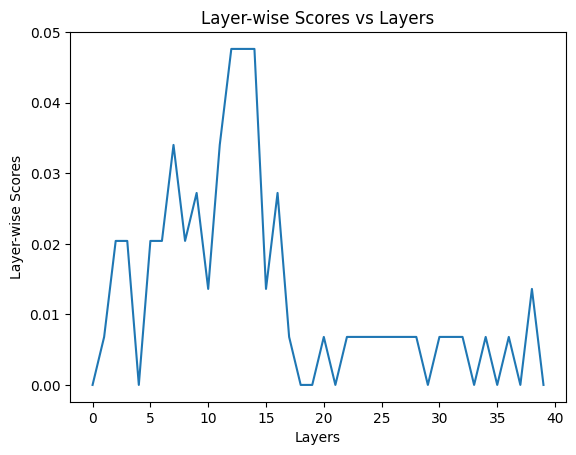

In [19]:
import matplotlib.pyplot as plt

plt.plot(list(range(model.cfg.n_layers)), layer_wise_scores)
plt.xlabel('Layers')
plt.ylabel('Layer-wise Scores')
plt.title('Layer-wise Scores vs Layers')
plt.show()

In [47]:
def chunkwise_sequence_patching_experiment(
    model, sequences, persona_source, persona_target, positions_to_patch, layers_to_patch
):
    scores = []
    baseline_diffs = []
    source_diffs = []
    patched_diffs = [] 

    for sequence in tqdm(sequences):
        target_prompt = persona_target + classifier_prompt.format(sequence=sequence)
        target_tokens = model.to_tokens(target_prompt)

        with torch.no_grad():
            baseline_logits = model(target_tokens).to("cpu")
        
        baseline_diff = clean_toxic_logit_diff(baseline_logits).item()


        source_prompt = persona_source + classifier_prompt.format(sequence=sequence)
        source_tokens = model.to_tokens(source_prompt)

        source_logits, source_cache = get_resid_cache_from_forward_pass(model, source_tokens)
        source_diff = clean_toxic_logit_diff(source_logits).item()

        temp_hook = partial(
            patching_hook,
            cache=source_cache,
            position=positions_to_patch,
        )
        for layer in layers_to_patch:
            model.blocks[layer].hook_resid_post.add_hook(temp_hook)

        with torch.no_grad():
            patched_logits = model(target_tokens).to("cpu")
        
        patched_logit_diff = clean_toxic_logit_diff(patched_logits).item()

        score = abs(patched_logit_diff - baseline_diff) / abs(source_diff - baseline_diff)
        scores.append(score)
        baseline_diffs.append(baseline_diff)
        source_diffs.append(source_diff)
        patched_diffs.append(patched_logit_diff)
            
        model.reset_hooks()

    return scores, baseline_diffs, source_diffs, patched_diffs

In [42]:
def chunkwise_persona_patching_experiment(
    model, persona_types, sequence_source, sequence_target, positions_to_patch, layers_to_patch
):
    scores = []
    baseline_diffs = []
    source_diffs = []
    patched_diffs = [] 

    for persona_type in tqdm(persona_types):
        persona_prompt = personas[persona_type]
        target_prompt = persona_prompt + classifier_prompt.format(sequence=sequence_target)
        target_tokens = model.to_tokens(target_prompt)

        with torch.no_grad():
            baseline_logits = model(target_tokens).to("cpu")
        
        baseline_diff = clean_toxic_logit_diff(baseline_logits).item()


        source_prompt = persona_prompt + classifier_prompt.format(sequence=sequence_source)
        source_tokens = model.to_tokens(source_prompt)

        source_logits, source_cache = get_resid_cache_from_forward_pass(model, source_tokens)
        source_diff = clean_toxic_logit_diff(source_logits).item()

        temp_hook = partial(
            patching_hook,
            cache=source_cache,
            position=positions_to_patch,
        )
        for layer in layers_to_patch:
            model.blocks[layer].hook_resid_post.add_hook(temp_hook)

        with torch.no_grad():
            patched_logits = model(target_tokens).to("cpu")
        
        patched_logit_diff = clean_toxic_logit_diff(patched_logits).item()

        score = abs(patched_logit_diff - baseline_diff) / abs(source_diff - baseline_diff)
        scores.append(score)
        baseline_diffs.append(baseline_diff)
        source_diffs.append(source_diff)
        patched_diffs.append(patched_logit_diff)
            
        model.reset_hooks()

    return scores, baseline_diffs, source_diffs, patched_diffs

In [56]:
model.reset_hooks()

In [31]:
sequence_positions = slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

scores, baseline_diffs, source_diffs, patched_diffs = chunkwise_sequence_patching_experiment(
    model,
    sequences=filtered_sequences[1:10], 
    persona_source=personas["lenient"],
    persona_target=personas["harsh"],
    positions_to_patch=sequence_positions,
    layers_to_patch=range(model.cfg.n_layers)
)

  0%|          | 0/9 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
 11%|█         | 1/9 [03:17<26:16, 197.08s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 22%|██▏       | 2/9 [07:30<26:51, 230.22s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 33%|███▎      | 3/9 [09:56<19:10, 191.83s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 44%|████▍     | 4/9 [13:50<17:22, 208.51s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 56%|█████▌    | 5/9 [16:52<13:15, 198.82s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 67%|██████▋   | 6/9 [19:48<09:33, 191.18s/it]Keyword arguments {'

In [61]:
scores

[0.034013605442176874,
 0.14,
 0.011111111111111112,
 0.022222222222222223,
 0.047619047619047616,
 0.04081632653061224,
 0.0,
 0.02,
 0.1590909090909091,
 0.037383177570093455]

In [35]:
np.mean(scores)

0.051225639958617265

In [36]:
print(np.mean(scores))

0.051225639958617265


In [38]:
print(np.std(scores))

0.051161032966802224


In [48]:
sequence_positions = slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

harsh_to_lenient_scores, baseline_diffs, source_diffs, patched_diffs = chunkwise_sequence_patching_experiment(
    model,
    sequences=filtered_sequences[:10], 
    persona_source=personas["harsh"],
    persona_target=personas["lenient"],
    positions_to_patch=sequence_positions,
    layers_to_patch=range(model.cfg.n_layers)
)

  0%|          | 0/10 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
 10%|█         | 1/10 [02:18<20:44, 138.25s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 20%|██        | 2/10 [04:20<17:10, 128.80s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 30%|███       | 3/10 [06:24<14:47, 126.74s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 40%|████      | 4/10 [08:12<11:56, 119.43s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 50%|█████     | 5/10 [10:07<09:48, 117.67s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 60%|██████    | 6/10 [11:48<07:28, 112.08s/it]Keyword argume

In [49]:
print(np.mean(harsh_to_lenient_scores))

0.05883271779399951


In [50]:
print(np.std(harsh_to_lenient_scores))

0.06265851443271325


In [43]:
sequence_positions = slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

p_patching_scores, baseline_diffs, source_diffs, patched_diffs = chunkwise_persona_patching_experiment(
    model,
    persona_types=personas.keys(),
    sequence_source="You are so stupid",
    sequence_target="You are so smart",
    positions_to_patch=sequence_positions,
    layers_to_patch=range(model.cfg.n_layers)
)

  0%|          | 0/2 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
 50%|█████     | 1/2 [02:35<02:35, 155.99s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
100%|██████████| 2/2 [04:54<00:00, 147.00s/it]


In [60]:
p_patching_scores_f1, baseline_diffs, source_diffs, patched_diffs = chunkwise_persona_patching_experiment(
    model,
    persona_types=personas.keys(),
    sequence_source="You are so stupid",
    sequence_target="You are so smart",
    positions_to_patch=-1,
    layers_to_patch=range(15)
)

  0%|          | 0/2 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 50%|█████     | 1/2 [00:46<00:46, 46.92s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
100%|██████████| 2/2 [01:26<00:00, 43.24s/it]


In [62]:
p_patching_scores_f1

[0.0842911877394636, 0.05263157894736842]

In [57]:
sequence_positions = slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

p_patching_scores2, baseline_diffs, source_diffs, patched_diffs = chunkwise_persona_patching_experiment(
    model,
    persona_types=personas.keys(),
    sequence_source="You are so smart",
    sequence_target="You are so stupid",
    positions_to_patch=sequence_positions,
    layers_to_patch=range(model.cfg.n_layers)
)

  0%|          | 0/2 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
 50%|█████     | 1/2 [02:45<02:45, 165.33s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
100%|██████████| 2/2 [04:59<00:00, 149.57s/it]


In [ ]:
p_patching_scores2

In [45]:
personas.keys()

dict_keys(['lenient', 'harsh'])

In [44]:
p_patching_scores

[1.0, 0.9970760233918129]

In [20]:
persona_source = personas["lenient"]
persona_target = personas["harsh"]

scores = []

for sequence in tqdm(filtered_sequences[:10]):
    target_prompt = persona_target + classifier_prompt.format(sequence=sequence)
    target_tokens = model.to_tokens(target_prompt)

    with torch.no_grad():
        baseline_logits = model(target_tokens).to("cpu")
    
    baseline_diff = clean_toxic_logit_diff(baseline_logits).item()


    source_prompt = persona_source + classifier_prompt.format(sequence=sequence)
    source_tokens = model.to_tokens(source_prompt)

    source_logits, source_cache = get_resid_cache_from_forward_pass(model, source_tokens)
    source_diff = clean_toxic_logit_diff(source_logits).item()

    positions_to_patch = slice(SEQUENCE_START_IDX, SEQUENCE_END_IDX)

    temp_hook = partial(
        patching_hook,
        cache=source_cache,
        position=positions_to_patch,
    )
    for layer in range(model.cfg.n_layers):
        model.blocks[layer].hook_resid_post.add_hook(temp_hook)

    with torch.no_grad():
        patched_logits = model(target_tokens).to("cpu")
    
    patched_logit_diff = clean_toxic_logit_diff(patched_logits).item()

    score = abs(patched_logit_diff - source_diff) / abs(baseline_diff - source_diff)
    scores.append(score)
        
    model.reset_hooks()

  0%|          | 0/10 [00:00<?, ?it/s]Keyword arguments {'add_special_tokens': False} not recognized.


Keyword arguments {'add_special_tokens': False} not recognized.
 10%|█         | 1/10 [03:56<35:31, 236.85s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 20%|██        | 2/10 [09:06<37:16, 279.57s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 30%|███       | 3/10 [12:07<27:22, 234.67s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 40%|████      | 4/10 [14:28<19:45, 197.62s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 50%|█████     | 5/10 [17:46<16:28, 197.66s/it]Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
 60%|██████    | 6/10 [19:35<11:11, 167.80s/it]Keyword argume

In [22]:
np.mean(scores)

1.0333635169162538